In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import plot_roc_curve

# Final Project DTSA 5509

## Introduction:

Welcome to my final project for this course. The goal for the project is to analyze the dataset to predict whether if a patient had a stroke or not.

## Data:
The dataset was found at kaggle.com (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

The dataset contains 12 columns, and 5110 rows, with the following features:
* 5 Categorical features (gender, ever_married, work_type, Residence_type and smoking_status)
* 3 Numerical features (age, avg_glucose_level and bmi)
* 3 Binary features (hypertension, heart_disease and stroke, 0 = have not, 1 = have)

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleaning:
The first step of the data cleaning is to remove the id column as this is not relevant to our analysis.

Second step is to check if the dataset have any null values, and it turns out, it has 201 values in the "bmi" column.

There are serveral ways of fill the na/null values, we can either fill them with mean, zero, or simply just drop them. But for this case, I decided to use K Nearest Neighbor impute function to generate the closet value and replace the na values. I used the age feature to estimate what bmi this person might have. 

In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
df = df.iloc[:,1:]

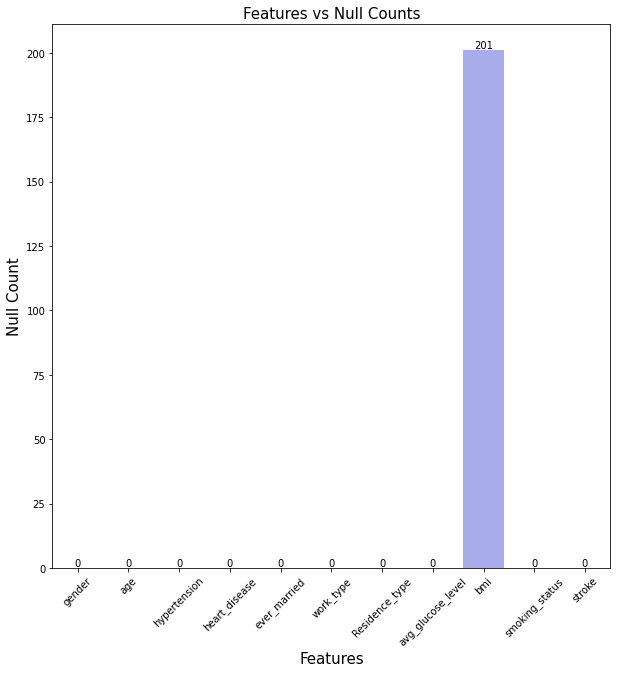

In [6]:
null_count = df.isnull().sum()

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=df.columns, y=null_count)
ax.bar_label(ax.containers[0])
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Null Count', fontsize = 15)
plt.title('Features vs Null Counts', fontsize = 15)
plt.xticks(fontsize = 10, horizontalalignment = 'center', rotation = 45)
plt.yticks(fontsize = 10)
plt.show()

In [7]:
imputer = KNNImputer(n_neighbors=5)
df_filled = imputer.fit_transform(df[['age','bmi']])
BMI = df_filled[:,1:].tolist()

In [8]:
lst = []
for i in range(len(BMI)):
    lst.append(BMI[i][0])

In [9]:
df['bmi'] = lst

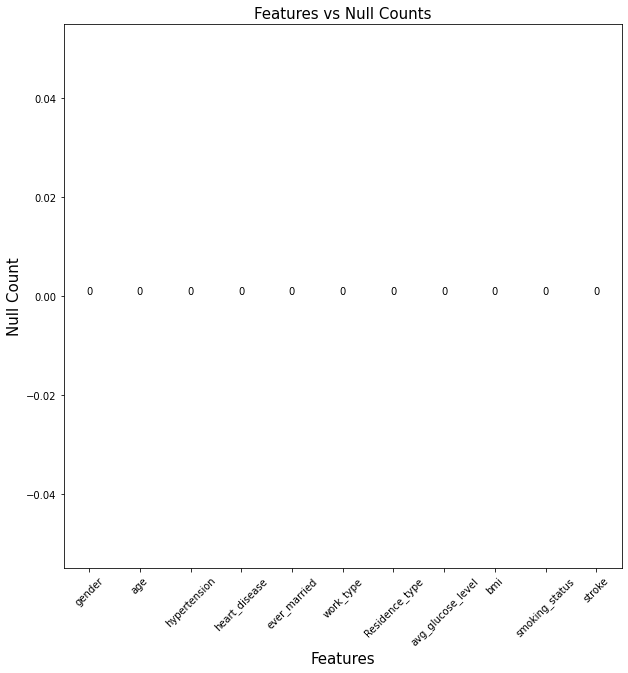

In [10]:
null_count2 = df.isnull().sum()
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=df.columns, y=null_count2)
ax.bar_label(ax.containers[0])
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Null Count', fontsize = 15)
plt.title('Features vs Null Counts', fontsize = 15)
plt.xticks(fontsize = 10, horizontalalignment = 'center', rotation = 45)
plt.yticks(fontsize = 10)
plt.show()

## Exploratory Data Analysis:
For the EDA, I have used bargraphs and histogram to analysis the dataset, here are the findings:
* 249 or 4.87 % of the people in this dataset had a stroke.
* 4861 or 95.13 % of the people in this dataset never had a stroke.
* 498 or 9.75 % of the people in this dataset have hypertension.
* 4612 or 90.25 % of the people in this dataset does not have hypertension.
* 276 or 5.4 % of the people in this dataset have heart disease.
* 4834 or 94.6 % of the people in this dataset does not have heart disease.
* The probability of a male having a stroke is: 5.11 %
* The probability of a female having a stroke is: 4.71 %
* The probability of a married person having a stroke is: 6.56 %
* The probability of a unmarried person having a stroke is: 1.65 %
* The probability of a private company worker having a stroke is: 5.09 %
* The probability of a self employed person having a stroke is: 7.94 %
* The probability of a government worker having a stroke is: 5.02 %
* The probability of a stay at home parent having a stroke is: 0.29 %
* The probability of a person that never worked having a stroke is: 0.0 %
* The probability of an urban person having a stroke is: 5.2 %
* The probability of a rural person having a stroke is: 4.53 %
* The probability of a former smoker having a stroke is: 7.91 %
* The probability of a never smoked person having a stroke is: 4.76 %
* The probability of a smoker having a stroke is: 5.32 %
* The probability of an unknown smoker having a stroke is: 3.04 %
* The average age of stroke victim is: 68
* The average age of a person never had a stroke is: 42
* The average bmi of stroke victim is: 30.4
* The average bmi of a person never had a stroke is: 28.86
* The average glucose level of stroke victim is: 132.54
* The average glucose level of a person never had a stroke is: 104.8

249 or 4.87 % of the people in this dataset had a stroke.
4861 or 95.13 % of the people in this dataset never had a stroke.


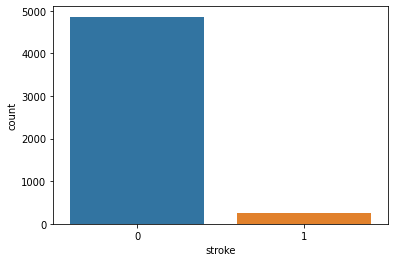

In [11]:
sns.countplot(data=df, x='stroke')
stroke_y = (len(df[df['stroke']==1])/len(df))
print(df.stroke.value_counts()[1], "or", round(stroke_y*100, 2), "% of the people in this dataset had a stroke.")
print(df.stroke.value_counts()[0], "or", round((1-stroke_y)*100, 2), "% of the people in this dataset never had a stroke.")

498 or 9.75 % of the people in this dataset have hypertension.
4612 or 90.25 % of the people in this dataset does not have hypertension.


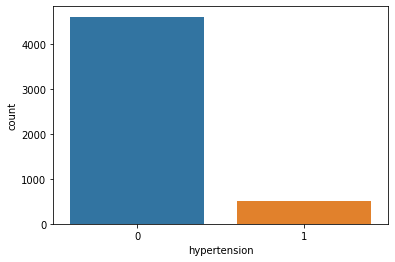

In [12]:
sns.countplot(data=df, x='hypertension')
hypertension_y = (len(df[df['hypertension']==1])/len(df))
print(df.hypertension.value_counts()[1], "or", round(hypertension_y*100, 2), "% of the people in this dataset have hypertension.")
print(df.hypertension.value_counts()[0], "or", round((1-hypertension_y)*100, 2), "% of the people in this dataset does not have hypertension.")

276 or 5.4 % of the people in this dataset have heart disease.
4834 or 94.6 % of the people in this dataset does not have heart disease.


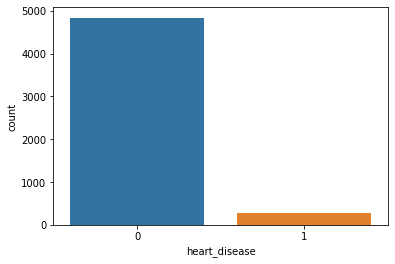

In [19]:
sns.countplot(data=df, x='heart_disease')
heart_disease_y = (len(df[df['heart_disease']==1])/len(df))
print(df.heart_disease.value_counts()[1], "or", round(heart_disease_y*100, 2), "% of the people in this dataset have heart disease.")
print(df.heart_disease.value_counts()[0], "or", round((1-heart_disease_y)*100, 2), "% of the people in this dataset does not have heart disease.")

<AxesSubplot:xlabel='age', ylabel='Count'>

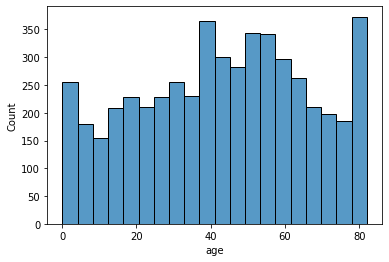

In [13]:
sns.histplot(data=df, x='age')

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

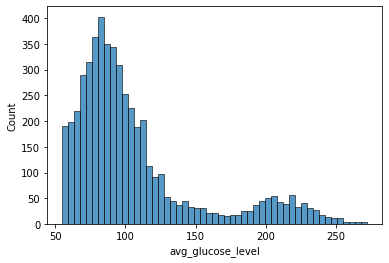

In [14]:
sns.histplot(data=df, x='avg_glucose_level')

<AxesSubplot:xlabel='bmi', ylabel='Count'>

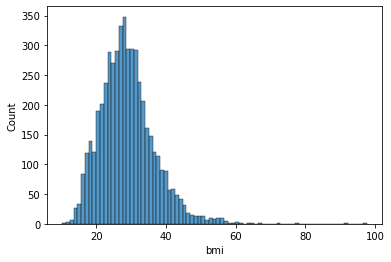

In [15]:
sns.histplot(data=df, x='bmi')

The probability of a male having a stroke is: 5.11 %
The probability of a female having a stroke is: 4.71 %


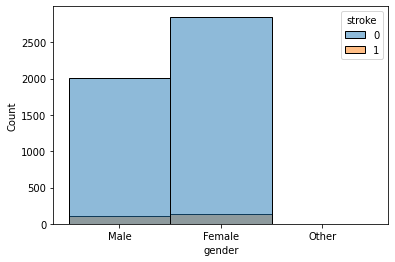

In [16]:
sns.histplot(data=df, x='gender', hue='stroke')
male_scount = len(df[(df.gender=='Male')&(df.stroke==1)])
male_count = len(df[(df.gender=='Male')])
percent_male = (male_scount/male_count)*100
female_scount = len(df[(df.gender=='Female')&(df.stroke==1)])
female_count = len(df[(df.gender=='Female')])
percent_female = (female_scount/female_count)*100
print("The probability of a male having a stroke is:", round(percent_male,2), "%")
print("The probability of a female having a stroke is:", round(percent_female,2), "%")

The probability of a married person having a stroke is: 6.56 %
The probability of a unmarried person having a stroke is: 1.65 %


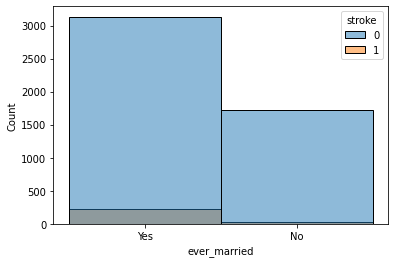

In [17]:
sns.histplot(data=df, x='ever_married', hue='stroke')
married_scount = len(df[(df.ever_married=='Yes')&(df.stroke==1)])
married_count = len(df[(df.ever_married=='Yes')])
percent_married = (married_scount/married_count)*100
unmarried_scount = len(df[(df.ever_married=='No')&(df.stroke==1)])
unmarried_count = len(df[(df.ever_married=='No')])
percent_unmarried = (unmarried_scount/unmarried_count)*100
print("The probability of a married person having a stroke is:", round(percent_married,2), "%")
print("The probability of a unmarried person having a stroke is:", round(percent_unmarried,2), "%")

The probability of a private company worker having a stroke is: 5.09 %
The probability of a self employed person having a stroke is: 7.94 %
The probability of a government worker having a stroke is: 5.02 %
The probability of a stay at home parent having a stroke is: 0.29 %
The probability of a person that never worked having a stroke is: 0.0 %


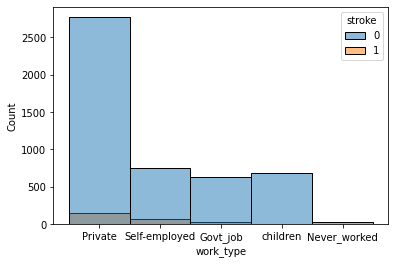

In [18]:
sns.histplot(data=df, x='work_type', hue='stroke')
private_scount = len(df[(df.work_type=='Private')&(df.stroke==1)])
private_count = len(df[(df.work_type=='Private')])
percent_private = (private_scount/private_count)*100
se_scount = len(df[(df.work_type=='Self-employed')&(df.stroke==1)])
se_count = len(df[(df.work_type=='Self-employed')])
percent_se = (se_scount/se_count)*100
gt_scount = len(df[(df.work_type=='Govt_job')&(df.stroke==1)])
gt_count = len(df[(df.work_type=='Govt_job')])
percent_gt = (gt_scount/gt_count)*100
ch_scount = len(df[(df.work_type=='children')&(df.stroke==1)])
ch_count = len(df[(df.work_type=='children')])
percent_ch = (ch_scount/ch_count)*100
nw_scount = len(df[(df.work_type=='Never_worked')&(df.stroke==1)])
nw_count = len(df[(df.work_type=='Never_worked')])
percent_nw = (nw_scount/nw_count)*100
print("The probability of a private company worker having a stroke is:", round(percent_private,2), "%")
print("The probability of a self employed person having a stroke is:", round(percent_se,2), "%")
print("The probability of a government worker having a stroke is:", round(percent_gt,2), "%")
print("The probability of a stay at home parent having a stroke is:", round(percent_ch,2), "%")
print("The probability of a person that never worked having a stroke is:", round(percent_nw,2), "%")

The probability of an urban person having a stroke is: 5.2 %
The probability of a rural person having a stroke is: 4.53 %


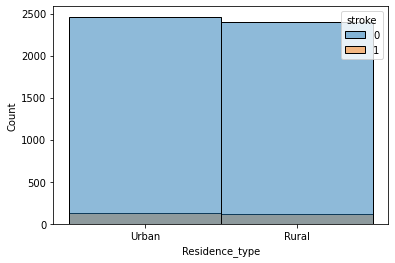

In [19]:
sns.histplot(data=df, x='Residence_type', hue='stroke')
urban_scount = len(df[(df.Residence_type=='Urban')&(df.stroke==1)])
urban_count = len(df[(df.Residence_type=='Urban')])
percent_urban = (urban_scount/urban_count)*100
rural_scount = len(df[(df.Residence_type=='Rural')&(df.stroke==1)])
rural_count = len(df[(df.Residence_type=='Rural')])
percent_rural = (rural_scount/rural_count)*100
print("The probability of an urban person having a stroke is:", round(percent_urban,2), "%")
print("The probability of a rural person having a stroke is:", round(percent_rural,2), "%")

The probability of a former smoker having a stroke is: 7.91 %
The probability of a never smoked person having a stroke is: 4.76 %
The probability of a smoker having a stroke is: 5.32 %
The probability of an unknown smoker having a stroke is: 3.04 %


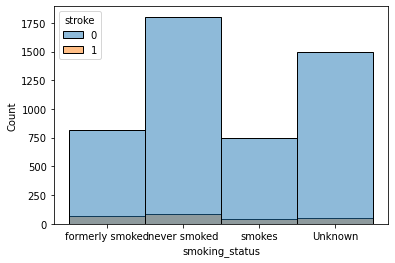

In [20]:
sns.histplot(data=df, x='smoking_status', hue='stroke')
fs_scount = len(df[(df.smoking_status=='formerly smoked')&(df.stroke==1)])
fs_count = len(df[(df.smoking_status=='formerly smoked')])
percent_fs = (fs_scount/fs_count)*100
ns_scount = len(df[(df.smoking_status=='never smoked')&(df.stroke==1)])
ns_count = len(df[(df.smoking_status=='never smoked')])
percent_ns = (ns_scount/ns_count)*100
sm_scount = len(df[(df.smoking_status=='smokes')&(df.stroke==1)])
sm_count = len(df[(df.smoking_status=='smokes')])
percent_sm = (sm_scount/sm_count)*100
un_scount = len(df[(df.smoking_status=='Unknown')&(df.stroke==1)])
un_count = len(df[(df.smoking_status=='Unknown')])
percent_un = (un_scount/un_count)*100
print("The probability of a former smoker having a stroke is:", round(percent_fs,2), "%")
print("The probability of a never smoked person having a stroke is:", round(percent_ns,2), "%")
print("The probability of a smoker having a stroke is:", round(percent_sm,2), "%")
print("The probability of an unknown smoker having a stroke is:", round(percent_un,2), "%")

The average age of stroke victim is: 68
The average age of a person never had a stroke is: 42


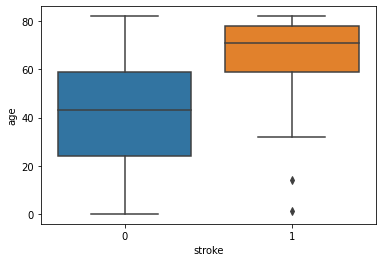

In [21]:
sns.boxplot(x='stroke', y='age', data=df)
print("The average age of stroke victim is:", round(df[(df.stroke==1)].age.mean()))
print("The average age of a person never had a stroke is:", round(df[(df.stroke==0)].age.mean()))

The average bmi of stroke victim is: 30.4
The average bmi of a person never had a stroke is: 28.86


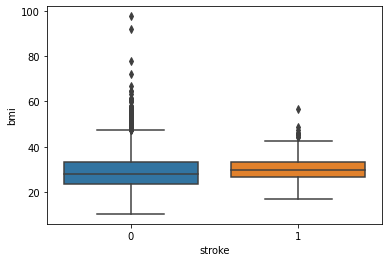

In [22]:
sns.boxplot(x='stroke', y='bmi', data=df)
print("The average bmi of stroke victim is:", round(df[(df.stroke==1)].bmi.mean(),2))
print("The average bmi of a person never had a stroke is:", round(df[(df.stroke==0)].bmi.mean(),2))

The average glucose level of stroke victim is: 132.54
The average glucose level of a person never had a stroke is: 104.8


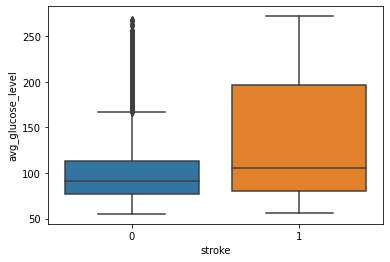

In [23]:
sns.boxplot(x='stroke', y='avg_glucose_level', data=df)
print("The average glucose level of stroke victim is:", round(df[(df.stroke==1)].avg_glucose_level.mean(),2))
print("The average glucose level of a person never had a stroke is:", round(df[(df.stroke==0)].avg_glucose_level.mean(),2))

In order to have a better correlation matrix visualization and modeling purposes, I transformed all categorical and binary values to numerical values.

In [24]:
le = LabelEncoder()
gen = le.fit_transform(df['gender'])
em = le.fit_transform(df['ever_married'])
wt = le.fit_transform(df['work_type'])
rt = le.fit_transform(df['Residence_type'])
ss = le.fit_transform(df['smoking_status'])

df['gender'] = gen
df['ever_married'] = em
df['work_type'] = wt
df['Residence_type'] = rt
df['smoking_status'] = ss
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.60,1,1
1,0,61.0,0,0,1,3,0,202.21,31.04,2,1
2,1,80.0,0,1,1,2,0,105.92,32.50,2,1
3,0,49.0,0,0,1,2,1,171.23,34.40,3,1
4,0,79.0,1,0,1,3,0,174.12,24.00,2,1


<AxesSubplot:>

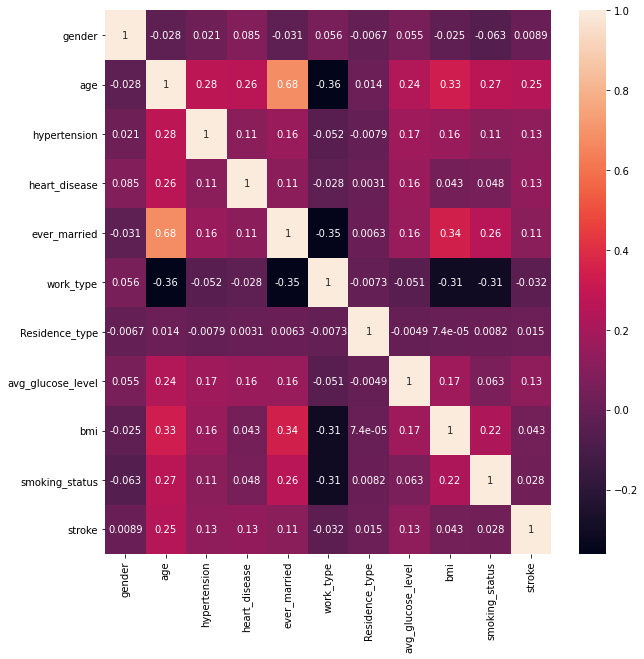

In [25]:
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)

From the correlation matrix, we can see that age, hypetension, heart disease and average glucose level are most correlated to having a stroke or not.

## Modeling:
For the modeling step, I set stroke as the response and all other features as predictors. Then compared the results using different classifiers to see which one returned the best results. I will also use 10-fold cross validation.

In [26]:
X = df.drop(['stroke'],axis=1)
y = df['stroke']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [28]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
models = []
results = []
accuracy_scores = []
predictions = []

models.append(['Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr')])
models.append(['KNearest Neighbor', KNeighborsClassifier()])
models.append(['Decision Tree Classifier', DecisionTreeClassifier()])
models.append(['Naive Bayes', GaussianNB()])
models.append(['SVM', SVC(gamma='auto')])
models.append(['Random Forest Classifier', RandomForestClassifier()])
models.append(['XG Boost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')])
models.append(['Ada Boost', AdaBoostClassifier()])
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append([cv_results.mean(), cv_results.std()])
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    accuracy_scores.append(accuracy_score(Y_test, y_pred))
    print(name, ':')
    print('Cross Validation Mean Score:', round(cv_results.mean(),3),',', 'Standard Deviation:', cv_results.std())
    print('Mean Absolute Error:', round(metrics.mean_absolute_error(Y_test, y_pred),2))
    print('Mean Squared Error:', round(metrics.mean_squared_error(Y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(Y_test, y_pred)),2))
    print('Accuracy Score:', round(accuracy_score(Y_test, y_pred),3))
    print('\n')


Logistic Regression :
Cross Validation Mean Score: 0.954 , Standard Deviation: 0.0007057484062171798
Mean Absolute Error: 0.06
Mean Squared Error: 0.06
Root Mean Squared Error: 0.24
Accuracy Score: 0.941


KNearest Neighbor :
Cross Validation Mean Score: 0.953 , Standard Deviation: 0.002128127086183517
Mean Absolute Error: 0.06
Mean Squared Error: 0.06
Root Mean Squared Error: 0.25
Accuracy Score: 0.936


Decision Tree Classifier :
Cross Validation Mean Score: 0.916 , Standard Deviation: 0.012489287172362279
Mean Absolute Error: 0.1
Mean Squared Error: 0.1
Root Mean Squared Error: 0.32
Accuracy Score: 0.9


Naive Bayes :
Cross Validation Mean Score: 0.87 , Standard Deviation: 0.019068624070125727
Mean Absolute Error: 0.14
Mean Squared Error: 0.14
Root Mean Squared Error: 0.37
Accuracy Score: 0.865


SVM :
Cross Validation Mean Score: 0.954 , Standard Deviation: 0.0007057484062171798
Mean Absolute Error: 0.06
Mean Squared Error: 0.06
Root Mean Squared Error: 0.24
Accuracy Score: 0.941



## ROC Curve
Logistic Regression performed the best with AUC of 0.85

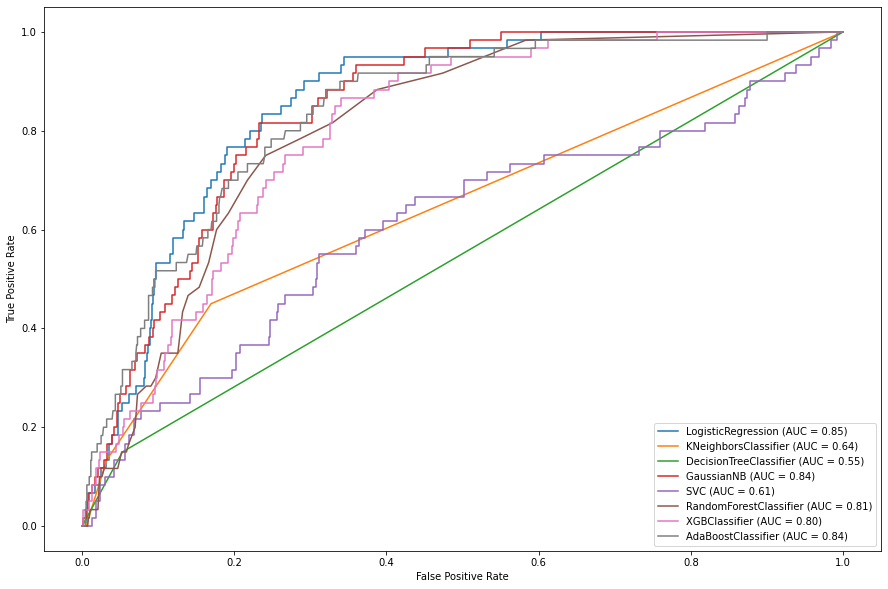

In [32]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
plot_roc_curve(models[0][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[1][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[2][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[3][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[4][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[5][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[6][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[7][1], X_test, Y_test, ax=ax)
plt.show()

## Accuracy Score
I ploted the accuracy scores of all the classifiers, Logistic Regression and SVM performed the best with score of 0.941, followed by Ada Boost with 0.940

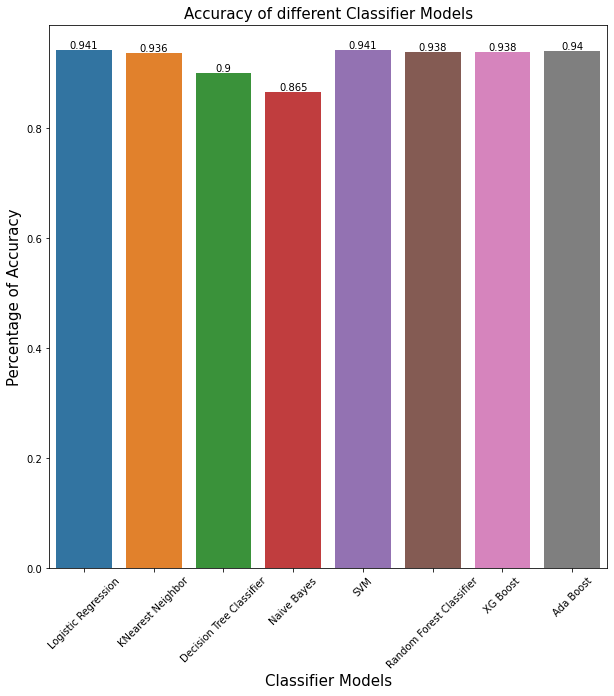

In [33]:
model_names = ['Logistic Regression','KNearest Neighbor','Decision Tree Classifier',
    'Naive Bayes','SVM','Random Forest Classifier','XG Boost','Ada Boost']
accuracy_scores = [round(score, 3) for score in accuracy_scores]

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=model_names, y=accuracy_scores)
ax.bar_label(ax.containers[0])
plt.xlabel('Classifier Models', fontsize = 15)
plt.ylabel('Percentage of Accuracy', fontsize = 15)
plt.title('Accuracy of different Classifier Models', fontsize = 15)
plt.xticks(fontsize = 10, horizontalalignment = 'center', rotation = 45)
plt.yticks(fontsize = 10)
plt.show()

## Confusion Matrix
The following shows confusion matrix for all classifiers.

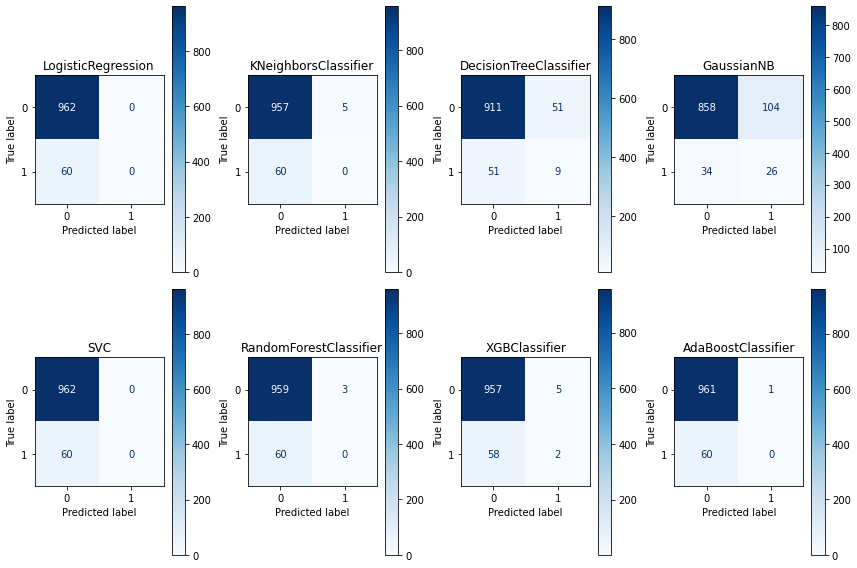

In [34]:
classifiers = []
for m in models:
    classifiers.append(m[1]) 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, X_test, Y_test, ax=ax, cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

## Results/Analysis:


## Discussion and Conclusion:
It seems like all the classifier performed well predicting the True Negative labels, however, they are not very good at predicting the True Positive Labels. Which means that these models had a hard time correctly predicting if a patient had a stroke.